In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.feature_extraction import DictVectorizer

from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("Book2.csv")
df.head()

,pipeline_length,inner_diameter,target_residual_conc,operating_pressure,temperature,num_bends,ambient_temperature,num_purge_cycles,safety_factor,pipeline_volume,nitrogen_volume_needed
0,1200,24,2.3,50.1,35.2,0,30.5,3,1.2,443,1594.8
1,800,18,1.8,40.7,28.3,2,32.1,2,1.1,209,459.8
2,1500,16,2.5,60.2,40.6,1,29.7,3,1.3,310,1209.0
3,600,14,2.1,35.4,25.0,0,33.3,2,1.0,113,226.0
4,1000,12,1.9,45.6,30.1,3,31.2,3,1.2,116,417.6


In [3]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.dtypes
df.isnull().sum()
df.nunique()
df.value_counts()
# df.duplicated().sum()

# df.describe()

pipeline_length  inner_diameter  target_residual_conc  operating_pressure  temperature  num_bends  ambient_temperature  num_purge_cycles  safety_factor  pipeline_volume  nitrogen_volume_needed
960              18              2.2                   42.8                29.5         1          33.4                 2                 1.1            241              530.2                     3
750              14              1.6                   31.8                24.8         0          36.3                 2                 1.0            138              276.0                     3
1440             24              2.4                   54.4                38.0         0          31.1                 3                 1.2            511              1839.6                    3
1650             16              2.5                   61.0                43.8         0          29.5                 3                 1.3            338              1317.6                    3
720            

In [4]:
df.nitrogen_volume_needed.describe()

count     500.000000
mean      720.574600
std       566.211111
min       108.000000
25%       258.000000
50%       497.200000
75%      1263.600000
max      1897.200000
Name: nitrogen_volume_needed, dtype: float64

In [5]:
# Filling missing values with median
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

df.head()

,pipeline_length,inner_diameter,target_residual_conc,operating_pressure,temperature,num_bends,ambient_temperature,num_purge_cycles,safety_factor,pipeline_volume,nitrogen_volume_needed
0,1200,24,2.3,50.1,35.2,0,30.5,3,1.2,443,1594.8
1,800,18,1.8,40.7,28.3,2,32.1,2,1.1,209,459.8
2,1500,16,2.5,60.2,40.6,1,29.7,3,1.3,310,1209.0
3,600,14,2.1,35.4,25.0,0,33.3,2,1.0,113,226.0
4,1000,12,1.9,45.6,30.1,3,31.2,3,1.2,116,417.6


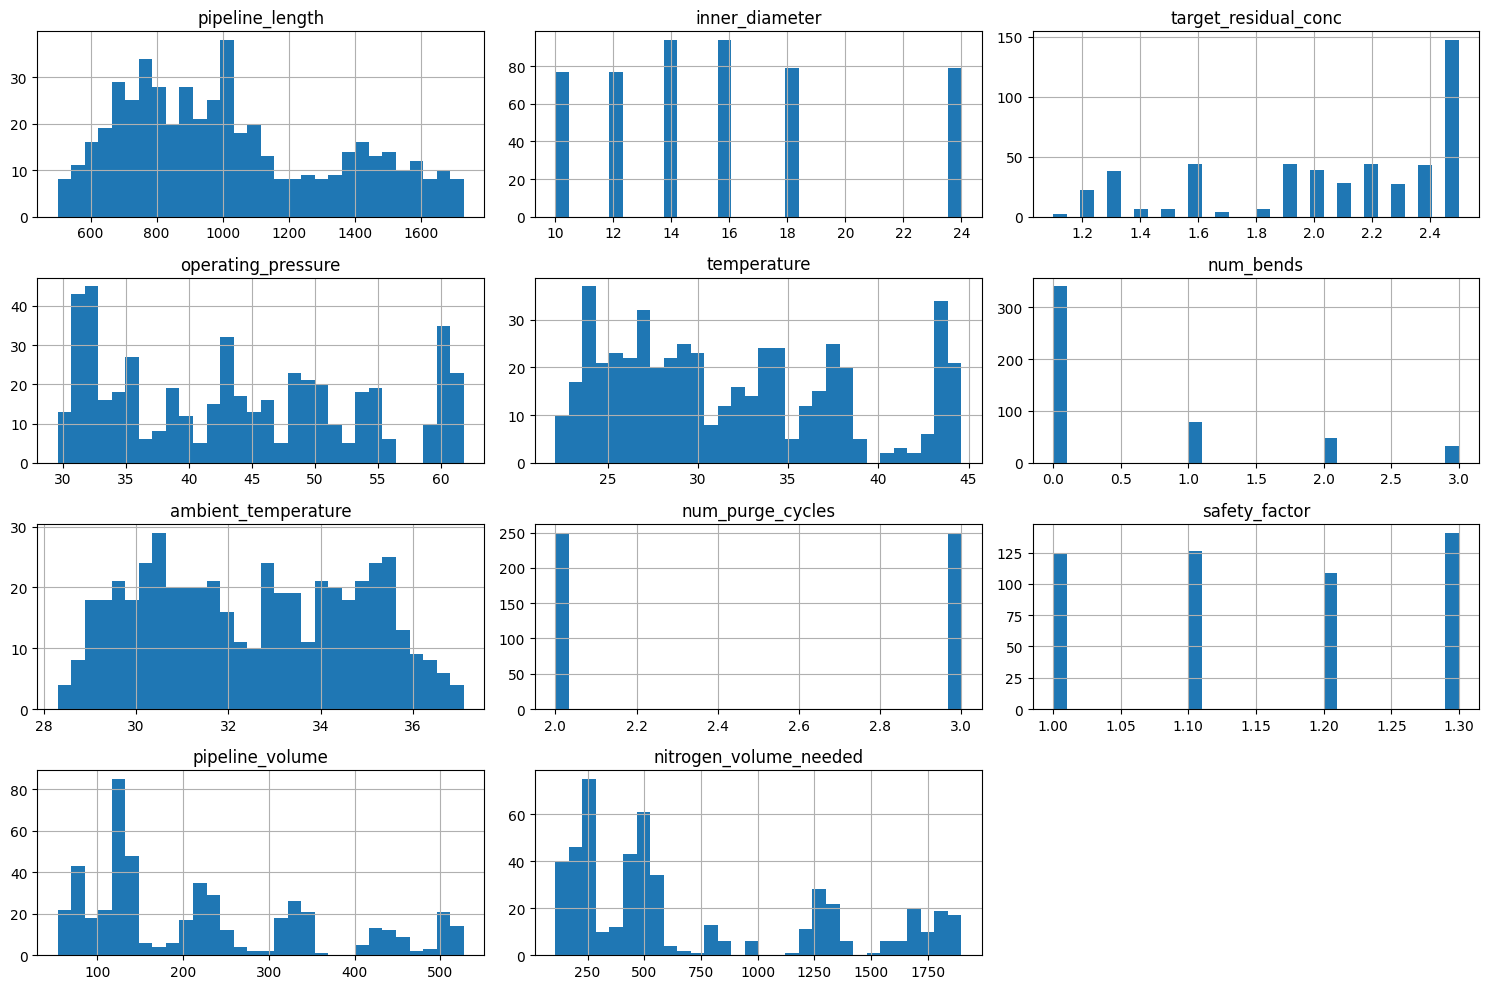

In [6]:
numeric_cols = df.select_dtypes(include='number').columns

# Histograms
df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

Splitting the data

In [7]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [9]:
y_train = df_train.nitrogen_volume_needed
y_val = df_val.nitrogen_volume_needed
y_test = df_test.nitrogen_volume_needed


del df_train['nitrogen_volume_needed']
del df_val['nitrogen_volume_needed']
del df_test['nitrogen_volume_needed']

In [10]:
dicts_train = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts_train)

dicts_val = df_val.to_dict(orient='records')
X_val = dv.transform(dicts_val)

In [11]:
len(df), len(df_train_full), len(df_train), len(df_val), len(df_test)

(500, 400, 300, 100, 100)

### Using Decision Tree Regressor
- Training with Decision Tree
- Tuning with Decision Tree

In [12]:
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 10, 15, 20], 'min_samples_leaf': [1, 2, 5, 10, 15, 20, 100, 200, 500]}

dt = DecisionTreeRegressor(random_state=1) 

dt = GridSearchCV(dt, parameters)

In [13]:
dt.fit(X_train, y_train)

,estimator,DecisionTreeR...andom_state=1)
,param_grid,"{'max_depth': [1, 2, ...], 'min_samples_leaf': [1, 2, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [14]:
dt.best_params_

{'max_depth': 20, 'min_samples_leaf': 1}

In [15]:
y_pred = dt.predict(X_val)
rmse_dt = root_mean_squared_error(y_val, y_pred)
rmse_dt

30.957927902235294

### Using Random forest Regressor
- Training with Random forest
- Tuning with Random forest

In [16]:
parameters = {
    'max_depth': [5, 10, 20],
    'n_estimators': [100, 300],
    'min_samples_leaf': [1, 5, 20]
}

rf = RandomForestRegressor(random_state=1)

rf_gs = GridSearchCV(
    rf,
    parameters,
    cv=5,                 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1            
)

In [17]:
rf_gs.fit(X_train, y_train)

,estimator,RandomForestR...andom_state=1)
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_leaf': [1, 5, ...], 'n_estimators': [100, 300]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [18]:
rf_gs.best_params_

{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}

In [19]:
y_pred = rf_gs.predict(X_val)

In [20]:
rmse_rf = root_mean_squared_error(y_val, y_pred)
print("Validation RMSE:", rmse_rf)

Validation RMSE: 27.959661597078856


### Applying Gradient boost

In [21]:
features = dv.get_feature_names_out().tolist()


dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [22]:
# Training the model

xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,     

    "objective": "reg:squarederror",
    "eval_metric": "rmse",             
    "nthread": 8,               
    
    "seed": 1,              
    "verbosity": 1    
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200) 

In [23]:
y_pred = model.predict(dval)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
rmse, r2

(24.526820139905357, 0.9981162530295328)

#### Tuning with XGBoost

In [24]:
from itertools import product

param_grid = {
    'eta': [0.1, 0.3, 1.0],
    'max_depth': [3, 4, 6, 10],
    'min_child_weight': [1, 3],
}

param_combinations = list(product(
    param_grid['eta'],
    param_grid['max_depth'],
    param_grid['min_child_weight']
))

In [25]:
best_rmse = float('inf')
best_params = None

for eta, max_depth, min_child_weight in param_combinations:
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'seed': 1,
        'verbosity': 0
    }

    model = xgb.train(params, dtrain, num_boost_round=200)
    y_pred = model.predict(dval)
    rmse = root_mean_squared_error(y_val, y_pred)

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best RMSE:", best_rmse)
print("Best Parameters:", best_params)

Best RMSE: 15.121103109373696
Best Parameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'seed': 1, 'verbosity': 0}


In [26]:
%%capture output

watchlist = [(dtrain, "train"), (dval, "val")]

params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'seed': 1,
        'verbosity': 0
    }

model = xgb.train(params, dtrain, num_boost_round=200, verbose_eval=10,
                  evals=watchlist)

In [27]:
s = output.stdout

print(s)

[0]	train-rmse:45.66964	val-rmse:50.97686
[10]	train-rmse:1.29800	val-rmse:27.75478
[20]	train-rmse:0.39550	val-rmse:27.78741
[30]	train-rmse:0.14304	val-rmse:27.68839
[40]	train-rmse:0.06134	val-rmse:27.69414
[50]	train-rmse:0.02453	val-rmse:27.68783
[60]	train-rmse:0.01156	val-rmse:27.68485
[70]	train-rmse:0.00505	val-rmse:27.68773
[80]	train-rmse:0.00220	val-rmse:27.68748
[90]	train-rmse:0.00127	val-rmse:27.68743
[100]	train-rmse:0.00127	val-rmse:27.68743
[110]	train-rmse:0.00127	val-rmse:27.68743
[120]	train-rmse:0.00127	val-rmse:27.68743
[130]	train-rmse:0.00127	val-rmse:27.68743
[140]	train-rmse:0.00127	val-rmse:27.68743
[150]	train-rmse:0.00127	val-rmse:27.68743
[160]	train-rmse:0.00127	val-rmse:27.68743
[170]	train-rmse:0.00127	val-rmse:27.68743
[180]	train-rmse:0.00127	val-rmse:27.68743
[190]	train-rmse:0.00127	val-rmse:27.68743
[199]	train-rmse:0.00127	val-rmse:27.68743



In [28]:
def parse_xgb_output(output):
    results = []
    for line in output.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        it = int(it_line.strip('[]'))
        train_rmse = float(train_line.split(':')[1])
        val_rmse = float(val_line.split(':')[1])
        results.append((it, train_rmse, val_rmse))
    tree = [r[0] for r in results]
    rmse_train = [r[1] for r in results]
    rmse_val = [r[2] for r in results]
    return tree, rmse_train, rmse_val

In [29]:
captured_text = output.stdout
tree, _, rmse_val = parse_xgb_output(captured_text)
print(min(rmse_val))

27.68485


In [30]:
min(zip(rmse_val, tree))

(27.68485, 60)

In [31]:
%%capture output

watchlist = [(dtrain, "train"), (dval, "val")]

params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'seed': 1,
        'verbosity': 0
    }

model = xgb.train(params, dtrain, num_boost_round=60, verbose_eval=10,
                  evals=watchlist)

In [32]:
y_pred = model.predict(dval)
rmse_xgb = root_mean_squared_error(y_val, y_pred)
rmse_xgb

27.684719748202248

Comparing All model rmse

In [33]:
rmse_xgb, rmse_rf, rmse_dt

(27.684719748202248, 27.959661597078856, 30.957927902235294)

Training the full train dataset

In [34]:
df_train_full = df_train_full.reset_index(drop=True)
df_train_full

,pipeline_length,inner_diameter,target_residual_conc,operating_pressure,temperature,num_bends,ambient_temperature,num_purge_cycles,safety_factor,pipeline_volume,nitrogen_volume_needed
0,1580,16,2.5,60.3,43.2,0,28.9,3,1.3,324,1263.6
1,1680,16,2.5,61.3,44.1,0,29.8,3,1.3,344,1342.2
2,850,10,1.9,35.6,27.5,0,35.4,2,1.1,84,184.8
3,1000,12,2.0,46.2,30.7,3,31.9,3,1.2,120,432.0
4,1070,16,2.0,44.0,32.3,0,31.6,3,1.2,229,824.4
...,...,...,...,...,...,...,...,...,...,...,...
395,760,10,1.9,34.6,26.5,0,34.3,2,1.1,75,165.0
396,1250,24,2.2,46.7,34.5,0,31.2,3,1.2,463,1666.8
397,1460,24,2.4,54.6,38.2,0,31.3,3,1.2,515,1854.0
398,750,10,1.9,34.5,26.4,0,34.2,2,1.1,73,160.6


In [35]:
y_train_full = df_train_full["nitrogen_volume_needed"]
del df_train_full["nitrogen_volume_needed"]

In [36]:
df_train_full

,pipeline_length,inner_diameter,target_residual_conc,operating_pressure,temperature,num_bends,ambient_temperature,num_purge_cycles,safety_factor,pipeline_volume
0,1580,16,2.5,60.3,43.2,0,28.9,3,1.3,324
1,1680,16,2.5,61.3,44.1,0,29.8,3,1.3,344
2,850,10,1.9,35.6,27.5,0,35.4,2,1.1,84
3,1000,12,2.0,46.2,30.7,3,31.9,3,1.2,120
4,1070,16,2.0,44.0,32.3,0,31.6,3,1.2,229
...,...,...,...,...,...,...,...,...,...,...
395,760,10,1.9,34.6,26.5,0,34.3,2,1.1,75
396,1250,24,2.2,46.7,34.5,0,31.2,3,1.2,463
397,1460,24,2.4,54.6,38.2,0,31.3,3,1.2,515
398,750,10,1.9,34.5,26.4,0,34.2,2,1.1,73


In [37]:
dicts_train_full = df_train_full.to_dict(orient="records")
dicts_test = df_test.to_dict(orient="records")

dv = DictVectorizer(sparse=False)
X_train_full = dv.fit_transform(dicts_train_full)
X_test = dv.transform(dicts_test)

In [38]:
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=dv.get_feature_names_out().tolist())
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.get_feature_names_out().tolist())


params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': 0.3,
        'max_depth': 3,
        'min_child_weight': 1,
        'seed': 1,
        'verbosity': 0
    }

model = xgb.train(params, dtrain_full, num_boost_round=60)

In [39]:
y_pred = model.predict(dtest)
rmse = root_mean_squared_error(y_test, y_pred)
rmse

13.155167542609513

In [40]:
import pickle

with open("model.bin", 'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [41]:
with open("model.bin", 'rb') as f_in:
    (dv, model) = pickle.load(f_in)

In [42]:
dv, model

(DictVectorizer(sparse=False), <xgboost.core.Booster at 0x19a54052440>)

In [43]:
nitrogen = {
  "pipeline_length": 1200,
  "inner_diameter": 24,
  "target_residual_conc": 2.3,
  "operating_pressure": 50.1,
  "temperature": 35.2,
  "num_bends": 0,
  "ambient_temperature": 30.5,
  "num_purge_cycles": 3,
  "safety_factor": 1.2,
  "pipeline_volume": 443
}

In [44]:
X = dv.transform([nitrogen])
X

array([[  30.5,   24. ,    0. ,    3. ,   50.1, 1200. ,  443. ,    1.2,
           2.3,   35.2]])

In [45]:
dtest = xgb.DMatrix(X, feature_names=dv.get_feature_names_out().tolist())
prediction = model.predict(dtest)
# prediction
print(f"Predicted nitrogen volume needed: {prediction[0]:.2f}")

Predicted nitrogen volume needed: 1604.01


Feature Importance Analysis

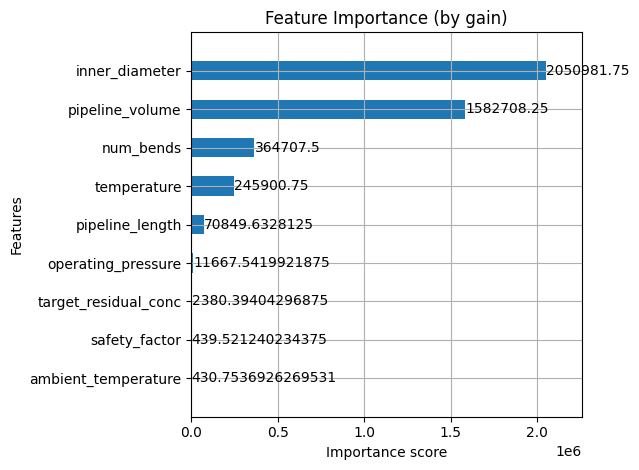

In [46]:
# Plot feature importance
xgb.plot_importance(model, importance_type='gain', max_num_features=10, height=0.5)
plt.title("Feature Importance (by gain)")
plt.tight_layout()
plt.show()